# Dual Model Pipeline dengan Feature Engineering

Notebook ini untuk **bearing failure prediction** dengan 2 model:
1. **Classification Model**: Memprediksi apakah bearing akan segera gagal (will_fail_soon)
2. **Regression Model**: Memprediksi berapa menit lagi sebelum failure (minutes_to_failure)

Kedua model menggunakan **feature engineering** lengkap dalam pipeline .pkl

## 1. Import Libraries

In [9]:
import json
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import TimeSeriesSplit, train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Custom Feature Engineering Transformer

In [10]:
class TimeSeriesFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Custom transformer untuk feature engineering time series data.
    """
    
    def __init__(self, feature_cols=None, rolling_windows=[3, 5, 10], 
                 lag_periods=[1, 2, 3], create_interactions=True, create_diffs=True):
        self.feature_cols = feature_cols
        self.rolling_windows = rolling_windows
        self.lag_periods = lag_periods
        self.create_interactions = create_interactions
        self.create_diffs = create_diffs
        self.engineered_feature_names_ = []
    
    def fit(self, X, y=None):
        if self.feature_cols is None:
            if isinstance(X, pd.DataFrame):
                self.feature_cols = X.select_dtypes(include=[np.number]).columns.tolist()
            else:
                raise ValueError("feature_cols harus dispesifikasi jika X bukan DataFrame")
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_cols)
        
        X_eng = X.copy()
        
        # 1. Rolling Statistics
        for col in self.feature_cols:
            if col not in X_eng.columns:
                continue
            for window in self.rolling_windows:
                X_eng[f'{col}_rolling_mean_{window}'] = X_eng[col].rolling(window=window, min_periods=1).mean()
                X_eng[f'{col}_rolling_std_{window}'] = X_eng[col].rolling(window=window, min_periods=1).std().fillna(0)
                X_eng[f'{col}_rolling_min_{window}'] = X_eng[col].rolling(window=window, min_periods=1).min()
                X_eng[f'{col}_rolling_max_{window}'] = X_eng[col].rolling(window=window, min_periods=1).max()
        
        # 2. Lag Features
        for col in self.feature_cols:
            if col not in X_eng.columns:
                continue
            for lag in self.lag_periods:
                X_eng[f'{col}_lag_{lag}'] = X_eng[col].shift(lag).fillna(method='bfill')
        
        # 3. Rate of Change
        if self.create_diffs:
            for col in self.feature_cols:
                if col not in X_eng.columns:
                    continue
                X_eng[f'{col}_diff'] = X_eng[col].diff().fillna(0)
                X_eng[f'{col}_pct_change'] = X_eng[col].pct_change().fillna(0).replace([np.inf, -np.inf], 0)
        
        # 4. Interaction Features
        if self.create_interactions and len(self.feature_cols) > 1:
            for i, col1 in enumerate(self.feature_cols):
                if col1 not in X_eng.columns:
                    continue
                for col2 in self.feature_cols[i+1:]:
                    if col2 not in X_eng.columns:
                        continue
                    X_eng[f'{col1}_x_{col2}'] = X_eng[col1] * X_eng[col2]
        
        self.engineered_feature_names_ = list(X_eng.columns)
        return X_eng
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.engineered_feature_names_)

print("✓ TimeSeriesFeatureEngineer class defined")

✓ TimeSeriesFeatureEngineer class defined


## 3. Load dan Prepare Data

In [11]:
# Load data
df = pd.read_csv('bearing_failure_data_bearing1_only.csv', skipinitialspace=True)
df.columns = [str(c).strip() for c in df.columns]

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.sort_values('timestamp').reset_index(drop=True)
df['is_failure'] = df['is_failure'].astype(str).str.strip().str.strip('"')

# Convert numeric columns
numeric_cols = ['mean_bearing_1', 'std_bearing_1', 'max_bearing_1', 'min_bearing_1']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['is_failure'].value_counts())
df.head()

Dataset shape: (984, 6)

Label distribution:
is_failure
N    983
Y      1
Name: count, dtype: int64


,timestamp,mean_bearing_1,std_bearing_1,max_bearing_1,min_bearing_1,is_failure
0,2004-02-12 10:32:39,-0.010196,0.073475,0.454,-0.386,N
1,2004-02-12 10:42:39,-0.002585,0.075338,0.369,-0.388,N
2,2004-02-12 10:52:39,-0.002484,0.076189,0.503,-0.400,N
3,2004-02-12 11:02:39,-0.002277,0.078691,0.608,-0.576,N
4,2004-02-12 11:12:39,-0.002404,0.078437,0.391,-0.391,N


## 4. Create Target Variables

Buat 2 target:
1. **minutes_to_failure**: Regresi - berapa menit lagi sebelum failure
2. **will_fail_soon**: Klasifikasi - apakah akan gagal dalam N menit

In [12]:
# Get failure timestamp
failure_rows = df[df['is_failure'] == 'Y']
if len(failure_rows) > 0:
    failure_timestamp = failure_rows['timestamp'].iloc[0]
    print(f"Failure timestamp: {failure_timestamp}")
else:
    raise ValueError("No failure found in dataset!")

# Calculate minutes to failure
df['minutes_to_failure'] = (failure_timestamp - df['timestamp']).dt.total_seconds() / 60.0
df['minutes_to_failure'] = df['minutes_to_failure'].clip(lower=0)

# Create classification target (will fail in next 300 minutes)
pre_failure_window = 300  # minutes
df['will_fail_soon'] = (df['minutes_to_failure'] <= pre_failure_window).astype(int)

print(f"\nMinutes to failure - Stats:")
print(df['minutes_to_failure'].describe())
print(f"\nWill fail soon distribution:")
print(df['will_fail_soon'].value_counts())

Failure timestamp: 2004-02-19 06:22:39

Minutes to failure - Stats:
count     984.000000
mean     4915.000000
std      2842.006334
min         0.000000
25%      2457.500000
50%      4915.000000
75%      7372.500000
max      9830.000000
Name: minutes_to_failure, dtype: float64

Will fail soon distribution:
will_fail_soon
0    953
1     31
Name: count, dtype: int64


## 5. Visualize Targets

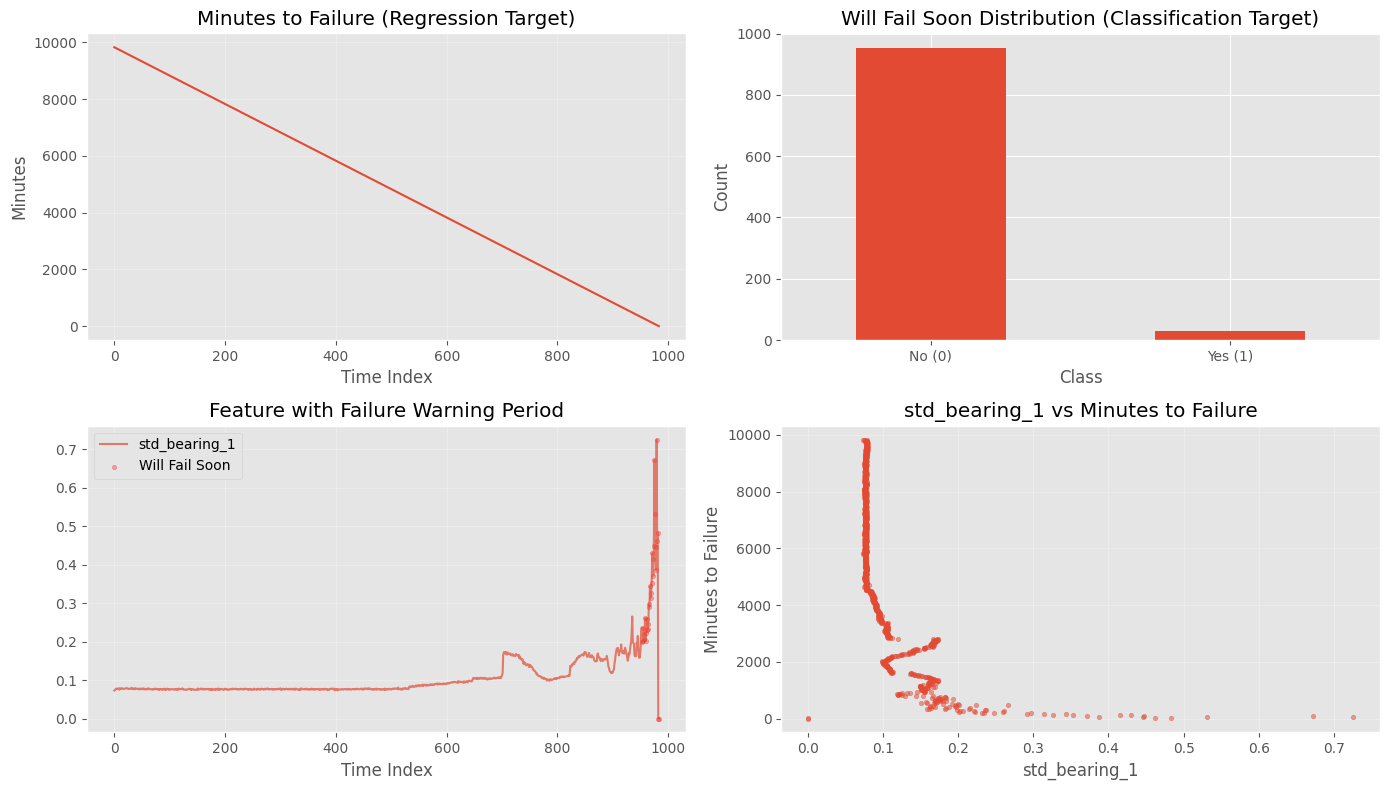

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Minutes to failure
axes[0, 0].plot(df.index, df['minutes_to_failure'])
axes[0, 0].set_title('Minutes to Failure (Regression Target)')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Minutes')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Will fail soon distribution
df['will_fail_soon'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Will Fail Soon Distribution (Classification Target)')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

# Plot 3: Feature over time with failure indicator
axes[1, 0].plot(df.index, df['std_bearing_1'], label='std_bearing_1', alpha=0.7)
failure_soon_idx = df[df['will_fail_soon'] == 1].index
axes[1, 0].scatter(failure_soon_idx, df.loc[failure_soon_idx, 'std_bearing_1'],
                   color='red', s=10, alpha=0.3, label='Will Fail Soon')
axes[1, 0].set_title('Feature with Failure Warning Period')
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Minutes to failure vs feature
axes[1, 1].scatter(df['std_bearing_1'], df['minutes_to_failure'], alpha=0.5, s=10)
axes[1, 1].set_title('std_bearing_1 vs Minutes to Failure')
axes[1, 1].set_xlabel('std_bearing_1')
axes[1, 1].set_ylabel('Minutes to Failure')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Prepare Data untuk Training

In [14]:
# Features
X = df[numeric_cols].copy()

# Targets
y_classification = df['will_fail_soon'].values
y_regression = df['minutes_to_failure'].values

# Stratified split (biar kelas 0/1 kebagian di train & test)
idx = np.arange(len(X))
train_idx, test_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=y_classification,
)

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_clf_train = y_classification[train_idx]
y_clf_test = y_classification[test_idx]
y_reg_train = y_regression[train_idx]
y_reg_test = y_regression[test_idx]

print(f"Train set: {len(X_train)} samples")
print(f"  - Classification positives: {y_clf_train.sum()} / {len(y_clf_train)}")
print(f"  - Regression target range: [{y_reg_train.min():.1f}, {y_reg_train.max():.1f}]")
print(f"\nTest set: {len(X_test)} samples")
print(f"  - Classification positives: {y_clf_test.sum()} / {len(y_clf_test)}")
print(f"  - Regression target range: [{y_reg_test.min():.1f}, {y_reg_test.max():.1f}]")

Train set: 787 samples
  - Classification positives: 25 / 787
  - Regression target range: [0.0, 9830.0]

Test set: 197 samples
  - Classification positives: 6 / 197
  - Regression target range: [50.0, 9820.0]


## 7. Build Pipeline Function

In [15]:
def build_pipeline(base_model, feature_cols, task_type='classification'):
    """
    Build pipeline dengan feature engineering.
    
    Parameters:
    -----------
    base_model : sklearn model
        Base model untuk classification atau regression
    feature_cols : list
        List of feature column names
    task_type : str
        'classification' or 'regression'
    """
    pipeline = Pipeline([
        ('feature_engineering', TimeSeriesFeatureEngineer(
            feature_cols=feature_cols,
            rolling_windows=[],
            lag_periods=[],
            create_interactions=False,
            create_diffs=False,
        )),
        ('preprocessing', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])),
        ('model', base_model)
    ])
    
    return pipeline

print("✓ Pipeline builder function defined")

✓ Pipeline builder function defined


## 8. Train Classification Models

In [16]:
# Define classification models
clf_models = {
    'LogisticRegression': LogisticRegression(max_iter=5000, class_weight='balanced', C=0.5),
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
    ),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
}

clf_results = []
clf_pipelines = {}

print("=" * 60)
print("TRAINING CLASSIFICATION MODELS (will_fail_soon)")
print("=" * 60)

for name, model in clf_models.items():
    print(f"\nTraining: {name}")
    
    # Build pipeline
    pipeline = build_pipeline(model, numeric_cols, 'classification')
    
    # Train
    pipeline.fit(X_train, y_clf_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_clf_test, y_pred)
    bal_acc = balanced_accuracy_score(y_clf_test, y_pred)
    f1 = f1_score(y_clf_test, y_pred, zero_division=0)
    prec, rec, _, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='binary', zero_division=0)

    # Cross-validation score
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for tr_idx, val_idx in skf.split(X_train, y_clf_train):
        X_tr = X_train.iloc[tr_idx]
        y_tr = y_clf_train[tr_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_clf_train[val_idx]

        temp_pipeline = build_pipeline(model, numeric_cols, 'classification')
        temp_pipeline.fit(X_tr, y_tr)
        pred = temp_pipeline.predict(X_val)
        cv_scores.append(f1_score(y_val, pred, zero_division=0))

    cv_f1 = float(np.mean(cv_scores)) if cv_scores else float('nan')

    result = {
        'model': name,
        'test_accuracy': acc,
        'test_balanced_accuracy': bal_acc,
        'test_f1': f1,
        'test_precision': prec,
        'test_recall': rec,
        'cv_f1': cv_f1,
    }
    clf_results.append(result)
    clf_pipelines[name] = pipeline
    
    print(f"  Test Accuracy: {acc:.4f}")
    print(f"  Test Balanced Acc: {bal_acc:.4f}")
    print(f"  Test F1: {f1:.4f}")
    print(f"  Test Precision: {prec:.4f}")
    print(f"  Test Recall: {rec:.4f}")
    print(f"  CV F1: {cv_f1:.4f}")

# Results
clf_results_df = pd.DataFrame(clf_results).sort_values('test_balanced_accuracy', ascending=False)
print(f"\n{'='*60}")
print("Classification Model Comparison")
print(f"{'='*60}")
print(clf_results_df.to_string(index=False))

TRAINING CLASSIFICATION MODELS (will_fail_soon)

Training: LogisticRegression
  Test Accuracy: 0.9594
  Test Balanced Acc: 0.8983
  Test F1: 0.5556
  Test Precision: 0.4167
  Test Recall: 0.8333
  CV F1: 0.5743

Training: RandomForest
  Test Accuracy: 0.9898
  Test Balanced Acc: 0.9948
  Test F1: 0.8571
  Test Precision: 0.7500
  Test Recall: 1.0000
  CV F1: 0.8822

Training: GradientBoosting
  Test Accuracy: 0.9898
  Test Balanced Acc: 0.9948
  Test F1: 0.8571
  Test Precision: 0.7500
  Test Recall: 1.0000
  CV F1: 0.7711

Classification Model Comparison
             model  test_accuracy  test_balanced_accuracy  test_f1  test_precision  test_recall    cv_f1
      RandomForest       0.989848                0.994764 0.857143        0.750000     1.000000 0.882222
  GradientBoosting       0.989848                0.994764 0.857143        0.750000     1.000000 0.771111
LogisticRegression       0.959391                0.898342 0.555556        0.416667     0.833333 0.574314


## 9. Train Regression Models

In [17]:
# Define regression models
reg_models = {
    'Ridge': Ridge(alpha=10.0),
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
    ),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, random_state=42),
}

reg_results = []
reg_pipelines = {}

tolerance_minutes = 300

print("=" * 60)
print("TRAINING REGRESSION MODELS (minutes_to_failure)")
print("=" * 60)

for name, model in reg_models.items():
    print(f"\nTraining: {name}")
    
    # Build pipeline
    pipeline = build_pipeline(model, numeric_cols, 'regression')
    
    # Train
    pipeline.fit(X_train, y_reg_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    
    # Metrics
    mae = mean_absolute_error(y_reg_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
    r2 = r2_score(y_reg_test, y_pred)
    tol_acc = float(np.mean(np.abs(y_reg_test - y_pred) <= tolerance_minutes))
    
    # Cross-validation score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_maes = []
    for tr_idx, val_idx in kf.split(X_train):
        X_tr = X_train.iloc[tr_idx]
        y_tr = y_reg_train[tr_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_reg_train[val_idx]
        
        temp_pipeline = build_pipeline(model, numeric_cols, 'regression')
        temp_pipeline.fit(X_tr, y_tr)
        pred = temp_pipeline.predict(X_val)
        pred = np.clip(pred, 0, None)
        cv_maes.append(mean_absolute_error(y_val, pred))
    
    cv_mae = float(np.mean(cv_maes)) if cv_maes else float('nan')
    
    result = {
        'model': name,
        'test_mae': mae,
        'test_rmse': rmse,
        'test_r2': r2,
        'test_tol_accuracy': tol_acc,
        'cv_mae': cv_mae,
    }
    reg_results.append(result)
    reg_pipelines[name] = pipeline
    
    print(f"  Test MAE: {mae:.2f} minutes")
    print(f"  Test RMSE: {rmse:.2f} minutes")
    print(f"  Test R²: {r2:.4f}")
    print(f"  Test Tol-Accuracy (±{tolerance_minutes} min): {tol_acc:.4f}")
    print(f"  CV MAE: {cv_mae:.2f} minutes")

# Results
reg_results_df = pd.DataFrame(reg_results).sort_values(['test_tol_accuracy', 'test_mae'], ascending=[False, True])
print(f"\n{'='*60}")
print("Regression Model Comparison")
print(f"{'='*60}")
print(reg_results_df.to_string(index=False))

TRAINING REGRESSION MODELS (minutes_to_failure)

Training: Ridge
  Test MAE: 1657.79 minutes
  Test RMSE: 1973.13 minutes
  Test R²: 0.5083
  Test Tol-Accuracy (±300 min): 0.1320
  CV MAE: 1619.43 minutes

Training: RandomForestRegressor
  Test MAE: 953.03 minutes
  Test RMSE: 1304.89 minutes
  Test R²: 0.7850
  Test Tol-Accuracy (±300 min): 0.3452
  CV MAE: 882.35 minutes

Training: GradientBoostingRegressor
  Test MAE: 941.86 minutes
  Test RMSE: 1295.22 minutes
  Test R²: 0.7881
  Test Tol-Accuracy (±300 min): 0.2640
  CV MAE: 961.17 minutes

Regression Model Comparison
                    model    test_mae   test_rmse  test_r2  test_tol_accuracy      cv_mae
    RandomForestRegressor  953.027636 1304.887954 0.784952           0.345178  882.353451
GradientBoostingRegressor  941.858203 1295.224910 0.788126           0.263959  961.168809
                    Ridge 1657.786809 1973.129018 0.508301           0.131980 1619.433765


## 10. Save Best Models

In [18]:
# Select best models
best_clf_name = clf_results_df.iloc[0]['model']
best_reg_name = reg_results_df.iloc[0]['model']

best_clf_pipeline = clf_pipelines[best_clf_name]
best_reg_pipeline = reg_pipelines[best_reg_name]

print(f"Best Classification Model: {best_clf_name}")
print(f"  Balanced Accuracy: {clf_results_df.iloc[0]['test_balanced_accuracy']:.4f}")
print(f"  F1 Score: {clf_results_df.iloc[0]['test_f1']:.4f}")
print(f"\nBest Regression Model: {best_reg_name}")
print(f"  Tol-Accuracy (±{tolerance_minutes} min): {reg_results_df.iloc[0]['test_tol_accuracy']:.4f}")
print(f"  MAE: {reg_results_df.iloc[0]['test_mae']:.2f} minutes")

# Create output directory
output_dir = Path('outputs_dual_fe_pipeline')
output_dir.mkdir(exist_ok=True)

# Save classification pipeline
clf_path = output_dir / 'klasifikasi.pkl'
dump(best_clf_pipeline, clf_path)
print(f"\n✓ Classification pipeline saved: {clf_path}")

# Save regression pipeline
reg_path = output_dir / 'prediksi.pkl'
dump(best_reg_pipeline, reg_path)
print(f"✓ Regression pipeline saved: {reg_path}")

# Save metadata
metadata = {
    'timestamp_col': 'timestamp',
    'feature_cols': numeric_cols,
    'label_col': 'is_failure',
    'positive_label': 'Y',
    'failure_timestamp': str(failure_timestamp),
    'pre_failure_minutes': pre_failure_window,
    'split': {
        'type': 'train_test_split_stratified',
        'test_size': 0.2,
        'random_state': 42,
    },
    'classification': {
        'model': best_clf_name,
        'target': 'will_fail_soon',
        'metrics': clf_results_df.iloc[0].to_dict(),
        'engineered_features': len(best_clf_pipeline.named_steps['feature_engineering'].engineered_feature_names_),
    },
    'regression': {
        'model': best_reg_name,
        'target': 'minutes_to_failure',
        'tolerance_minutes': tolerance_minutes,
        'metrics': reg_results_df.iloc[0].to_dict(),
        'engineered_features': len(best_reg_pipeline.named_steps['feature_engineering'].engineered_feature_names_),
    },
    'created_at': datetime.now().isoformat(),
}

with open(output_dir / 'artifacts_meta.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved: {output_dir / 'artifacts_meta.json'}")

Best Classification Model: RandomForest
  Balanced Accuracy: 0.9948
  F1 Score: 0.8571

Best Regression Model: RandomForestRegressor
  Tol-Accuracy (±300 min): 0.3452
  MAE: 953.03 minutes

✓ Classification pipeline saved: outputs_dual_fe_pipeline\klasifikasi.pkl
✓ Regression pipeline saved: outputs_dual_fe_pipeline\prediksi.pkl
✓ Metadata saved: outputs_dual_fe_pipeline\artifacts_meta.json


## 11. Classification Report

In [19]:
# Classification report
y_clf_pred = best_clf_pipeline.predict(X_test)
report = classification_report(y_clf_test, y_clf_pred, target_names=['No', 'Yes'])
print("Classification Report (will_fail_soon):")
print(report)

# Save
report_dict = classification_report(y_clf_test, y_clf_pred, target_names=['No', 'Yes'], output_dict=True)
with open(output_dir / 'classification_report.json', 'w') as f:
    json.dump(report_dict, f, indent=2)

# Regression metrics
y_reg_pred = best_reg_pipeline.predict(X_test)
y_reg_pred = np.clip(y_reg_pred, 0, None)
reg_metrics = {
    'mae': float(mean_absolute_error(y_reg_test, y_reg_pred)),
    'rmse': float(np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))),
    'r2': float(r2_score(y_reg_test, y_reg_pred)),
    'tol_accuracy': float(np.mean(np.abs(y_reg_test - y_reg_pred) <= tolerance_minutes)),
    'tolerance_minutes': tolerance_minutes,
}

print(f"\nRegression Metrics (minutes_to_failure):")
print(f"  MAE: {reg_metrics['mae']:.2f} minutes")
print(f"  RMSE: {reg_metrics['rmse']:.2f} minutes")
print(f"  R²: {reg_metrics['r2']:.4f}")
print(f"  Tol-Accuracy (±{tolerance_minutes} min): {reg_metrics['tol_accuracy']:.4f}")

with open(output_dir / 'regression_metrics.json', 'w') as f:
    json.dump(reg_metrics, f, indent=2)

Classification Report (will_fail_soon):
              precision    recall  f1-score   support

          No       1.00      0.99      1.00       191
         Yes       0.86      1.00      0.92         6

    accuracy                           0.99       197
   macro avg       0.93      1.00      0.96       197
weighted avg       1.00      0.99      1.00       197


Regression Metrics (minutes_to_failure):
  MAE: 932.55 minutes
  RMSE: 1239.34 minutes
  R²: 0.8060
  Tol-Accuracy (±300 min): 0.2995


## 12. Visualizations

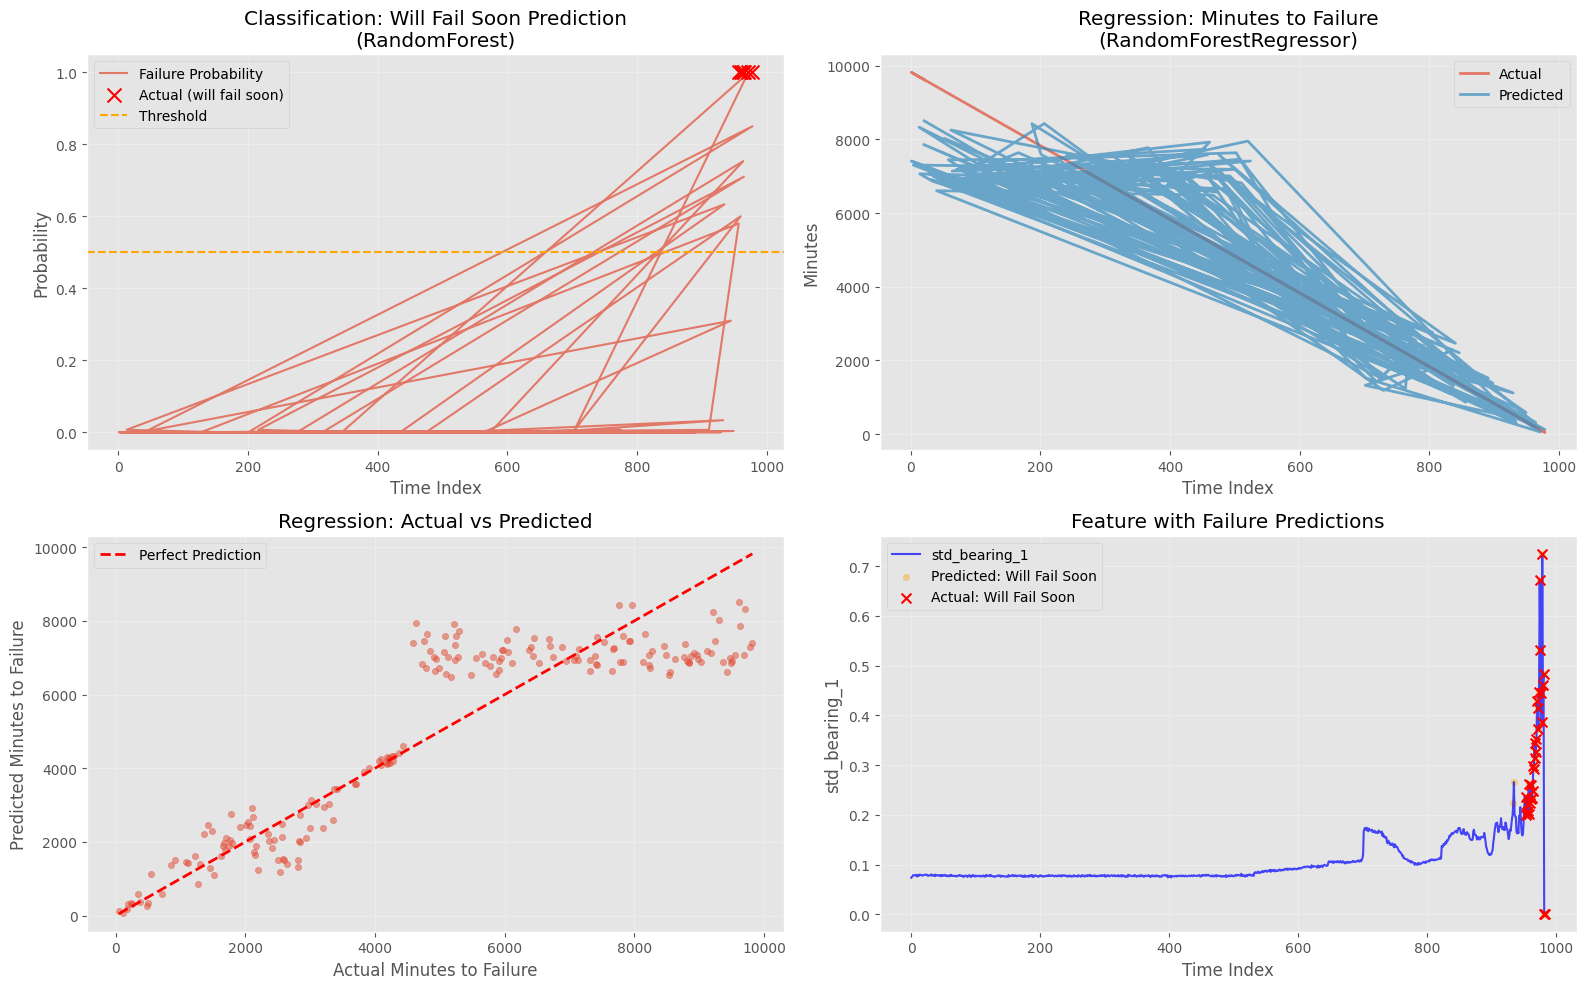

✓ Visualization saved to outputs_dual_fe_pipeline


In [20]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Classification predictions
y_clf_proba = best_clf_pipeline.predict_proba(X_test)[:, 1]
axes[0, 0].plot(X_test.index, y_clf_proba, label='Failure Probability', alpha=0.7)
axes[0, 0].scatter(X_test[y_clf_test == 1].index, [1]*sum(y_clf_test),
                   color='red', marker='x', s=100, label='Actual (will fail soon)', zorder=5)
axes[0, 0].axhline(0.5, color='orange', linestyle='--', label='Threshold')
axes[0, 0].set_title(f'Classification: Will Fail Soon Prediction\n({best_clf_name})')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Probability')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Regression predictions
axes[0, 1].plot(X_test.index, y_reg_test, label='Actual', alpha=0.7, linewidth=2)
axes[0, 1].plot(X_test.index, y_reg_pred, label='Predicted', alpha=0.7, linewidth=2)
axes[0, 1].set_title(f'Regression: Minutes to Failure\n({best_reg_name})')
axes[0, 1].set_xlabel('Time Index')
axes[0, 1].set_ylabel('Minutes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Regression scatter (actual vs predicted)
axes[1, 0].scatter(y_reg_test, y_reg_pred, alpha=0.5, s=20)
min_val = min(y_reg_test.min(), y_reg_pred.min())
max_val = max(y_reg_test.max(), y_reg_pred.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Regression: Actual vs Predicted')
axes[1, 0].set_xlabel('Actual Minutes to Failure')
axes[1, 0].set_ylabel('Predicted Minutes to Failure')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature with both predictions
axes[1, 1].plot(df.index, df['std_bearing_1'], label='std_bearing_1', alpha=0.7, color='blue')
# Get predictions for full dataset
y_clf_full = best_clf_pipeline.predict(X)
fail_pred_idx = df[y_clf_full == 1].index
axes[1, 1].scatter(fail_pred_idx, df.loc[fail_pred_idx, 'std_bearing_1'],
                   color='orange', s=20, alpha=0.4, label='Predicted: Will Fail Soon')
axes[1, 1].scatter(df[df['will_fail_soon'] == 1].index, df.loc[df['will_fail_soon'] == 1, 'std_bearing_1'],
                   color='red', marker='x', s=50, label='Actual: Will Fail Soon', zorder=5)
axes[1, 1].set_title('Feature with Failure Predictions')
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('std_bearing_1')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'dual_model_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to {output_dir}")

## 13. Demo: Load dan Predict dengan Saved Models

In [21]:
# Load pipelines
loaded_clf = load(clf_path)
loaded_reg = load(reg_path)
print("✓ Pipelines loaded successfully\n")

# Predict on new data (contoh: 10 sample terakhir)
X_new = X.tail(10)

# Classification predictions
clf_pred = loaded_clf.predict(X_new)
clf_proba = loaded_clf.predict_proba(X_new)[:, 1]

# Regression predictions
reg_pred = loaded_reg.predict(X_new)
reg_pred = np.clip(reg_pred, 0, None)

# Show results
result_df = pd.DataFrame({
    'index': X_new.index,
    'will_fail_soon': ['Yes' if p == 1 else 'No' for p in clf_pred],
    'failure_probability': clf_proba,
    'minutes_to_failure': reg_pred,
})

print("Prediction Results (Last 10 samples):")
print(result_df.to_string(index=False))

print("\n" + "="*70)
print("IMPORTANT: Kedua pipeline sudah include preprocessing!")
print("Anda hanya perlu pass raw features [mean, std, max, min]")
print("Pipeline akan otomatis:")
print("  1. Imputation & scaling")
print("  2. Predict dengan model")
print("\nKlasifikasi: Apakah akan gagal dalam 300 menit?")
print("Regresi: Berapa menit lagi sebelum gagal?")
print("="*70)

✓ Pipelines loaded successfully

Prediction Results (Last 10 samples):
 index will_fail_soon  failure_probability  minutes_to_failure
   974            Yes             1.000000           79.166667
   975            Yes             0.920000           68.955000
   976            Yes             1.000000           59.255000
   977            Yes             1.000000           60.594444
   978            Yes             0.850000          124.733333
   979            Yes             1.000000           51.627778
   980            Yes             1.000000           48.861111
   981            Yes             0.956667           40.733333
   982            Yes             0.843333          900.329264
   983            Yes             0.783333         1353.827493

IMPORTANT: Kedua pipeline sudah include preprocessing!
Anda hanya perlu pass raw features [mean, std, max, min]
Pipeline akan otomatis:
  1. Imputation & scaling
  2. Predict dengan model

Klasifikasi: Apakah akan gagal dalam 300 menit

## Summary

### Dual Model Pipeline yang dibuat:

#### 1. Classification Pipeline (`klasifikasi.pkl`):
- **Target**: `will_fail_soon` (0/1)
- **Prediksi**: Apakah bearing akan gagal dalam 300 menit ke depan?
- **Output**: 
  - Binary prediction (0 = No, 1 = Yes)
  - Probability score

#### 2. Regression Pipeline (`prediksi.pkl`):
- **Target**: `minutes_to_failure`
- **Prediksi**: Berapa menit lagi sebelum bearing gagal?
- **Output**: 
  - Continuous value (menit)

### Feature Engineering (di kedua pipeline):
1. Rolling statistics (window 3, 5, 10)
2. Lag features (1, 2, 3 periods)
3. Rate of change (diff, pct_change)
4. Interaction features

### Files yang disimpan:
- `klasifikasi.pkl` - Classification pipeline
- `prediksi.pkl` - Regression pipeline
- `artifacts_meta.json` - Metadata lengkap
- `classification_report.json` - Classification metrics
- `regression_metrics.json` - Regression metrics
- `dual_model_predictions.png` - Visualizations

### Cara menggunakan:
```python
from joblib import load

# Load models
clf_model = load('outputs_dual_fe_pipeline/klasifikasi.pkl')
reg_model = load('outputs_dual_fe_pipeline/prediksi.pkl')

# Predict (hanya perlu raw features!)
will_fail = clf_model.predict(X_new)
failure_prob = clf_model.predict_proba(X_new)[:, 1]
minutes_left = reg_model.predict(X_new)
```